# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt


from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

In [4]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [5]:
X_train = pd.read_parquet('train.parquet.gzip') 
X_train.shape

y_train = X_train.target

In [6]:
X_test = pd.read_parquet('test.parquet.gzip') 
X_test.shape

y_test = X_test.target

In [7]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

Padronização dos dados

In [8]:
file_std = "./models/std.pkl"

std = joblib.load(file_std)

In [9]:
X_train = std.transform(X_train[VARS])

X_test = std.transform(X_test[VARS])


X_train = pd.DataFrame(X_train, columns=VARS)
X_test = pd.DataFrame(X_test, columns=VARS)

In [10]:
train = X_train.copy()
train['target'] = pd.DataFrame(y_train).reset_index(drop=True)

test = X_test.copy()
test['target'] = pd.DataFrame(y_test).reset_index(drop=True) 

In [11]:
del X_train
del X_test

In [12]:
for i in VARS:
    train[i] = train[i].astype(float)

for i in VARS:
    test[i] = test[i].astype(float)

In [13]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,target
0,0.181717,-0.067052,0.383296,0.378668,-0.143013,-0.258549,-0.367398,0
1,0.181717,-0.059488,-2.334315,0.507568,-1.197005,3.852346,2.656535,1
2,0.181717,-0.103709,-0.392971,-0.591428,-0.865057,-0.227385,-0.367398,1
3,0.181717,-0.088803,0.476565,-0.798487,0.284237,-0.266656,-0.367398,0
4,0.181717,-0.057298,0.448476,0.742694,3.003116,-0.256197,-0.367398,1


#### Isolation Forest

In [12]:
with open('./models/iForest.pkl', 'rb') as f:
    iforest = pickle.load(f) 

In [13]:
train['scores_forest']=iforest.decision_function(train[VARS])
train['iForest']=iforest.predict(train[VARS])
train['iForest'] = train['iForest'].apply(lambda x: 1 if x<0 else 0)

In [14]:
test['scores_forest']=iforest.decision_function(test[VARS])
test['iForest']=iforest.predict(test[VARS])
test['iForest'] = test['iForest'].apply(lambda x: 1 if x<0 else 0)

In [15]:
test['iForest'].value_counts()

iForest
0    2332289
1    1000405
Name: count, dtype: int64

<Axes: xlabel='scores_forest', ylabel='Density'>

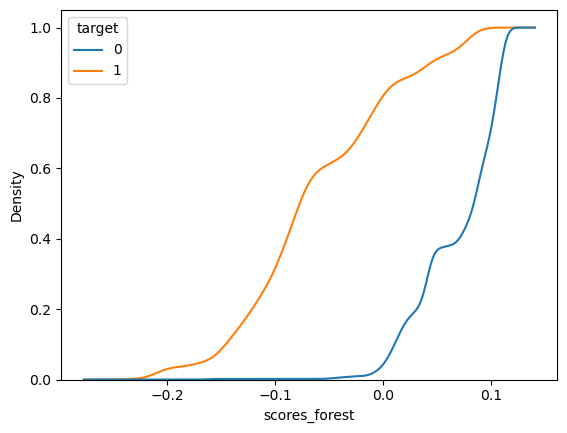

In [16]:
sns.kdeplot(
    data=train.sample(frac=0.01), x="scores_forest", hue=train.target,
    cumulative=True, common_norm=False, common_grid=True,
)

<Axes: xlabel='scores_forest', ylabel='Density'>

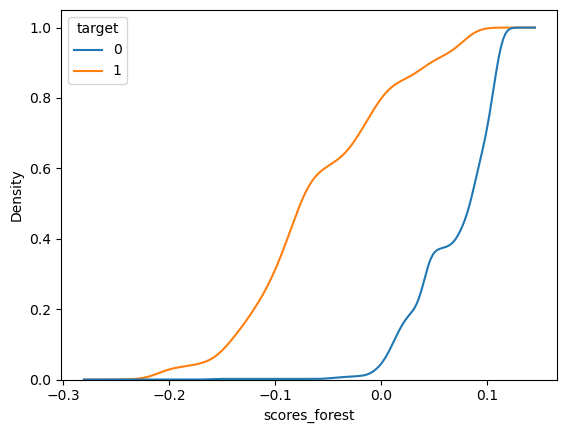

In [17]:
sns.kdeplot(
    data=test.sample(frac=0.01), x="scores_forest", hue=test.target,
    cumulative=True, common_norm=False, common_grid=True,
)

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93   5156118
           1       0.91      0.81      0.86   2620165

    accuracy                           0.91   7776283
   macro avg       0.91      0.88      0.90   7776283
weighted avg       0.91      0.91      0.91   7776283

Specificity: 0.9593263769370678
Gini:  0.7696444294261284
ROC AUC::  0.8848222147130642


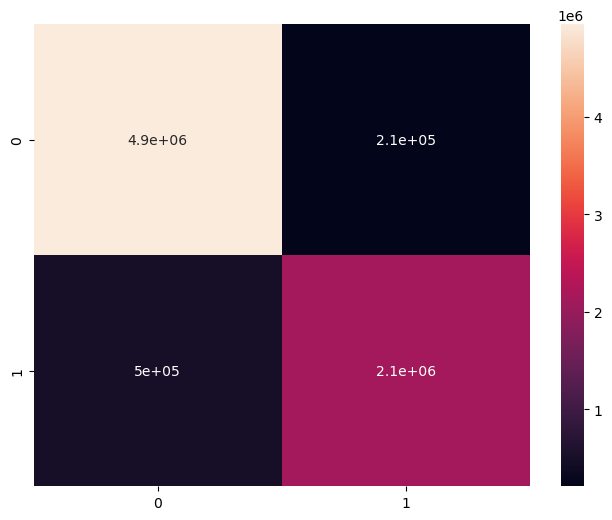

In [64]:
metrics(train.target, train.iForest)

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93   2209766
           1       0.91      0.81      0.86   1122928

    accuracy                           0.91   3332694
   macro avg       0.91      0.88      0.90   3332694
weighted avg       0.91      0.91      0.91   3332694

Specificity: 0.9592517940813643
Gini:  0.7699547064675547
ROC AUC::  0.8849773532337774


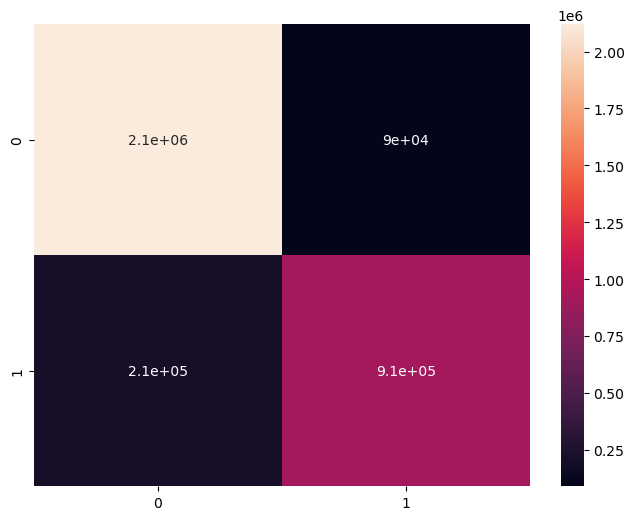

In [65]:
metrics(test.target, test.iForest)

#### Explainable

In [33]:
import shap

In [52]:
test_sample = test[VARS].sample(frac=0.01)
test_sample.shape

(33327, 7)

In [53]:
test_sample.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
2447209,0.181717,-0.068085,0.429235,0.343852,-0.141127,-0.258319,-0.367398
2929790,0.181717,-0.046931,0.483485,-0.578866,0.169944,-0.267478,-0.367398
2970535,0.181717,-0.032458,0.378091,2.154543,-0.408163,-0.263354,-0.367398
3308926,0.181717,-0.088729,0.476597,-0.823233,0.266711,-0.266656,-0.367398
1815859,0.181717,-0.068316,-1.030000,0.539561,-1.316186,-0.227223,-0.367398


In [54]:
exp = shap.TreeExplainer(iforest) #Explainer
shap_values = exp.shap_values(test_sample)  #Calculate SHAP values
shap.initjs()

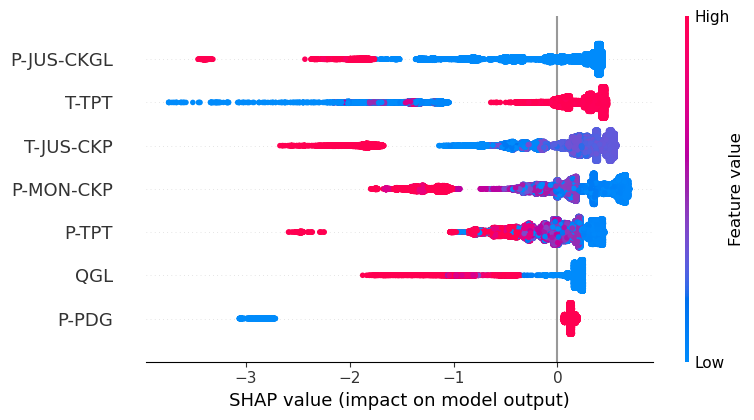

In [55]:
shap.summary_plot(shap_values, test_sample)

In [61]:
test.head(3)

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,target,scores_forest,iForest
0,0.181717,-0.056225,0.429764,0.828057,3.003116,-0.256049,-0.367398,1,-0.004209,1
1,0.181717,-0.046850,0.484157,-0.579127,0.170006,-0.267478,-0.367398,0,0.043108,0
2,0.181717,-0.066376,0.395969,0.435403,-0.162217,-0.259144,-0.367398,0,0.088761,0


In [62]:
shap.force_plot(exp.expected_value, shap_values[2],features =test_sample.iloc[2,:] ,feature_names =test_sample.columns)

#### PCA

In [66]:
with open('./models/PCA.pkl', 'rb') as f:
    clf_PCA = pickle.load(f) 

In [67]:
test['PCA']=clf_PCA.predict(test[VARS])

In [68]:
test['PCA'].value_counts()

PCA
0    2333318
1     999376
Name: count, dtype: int64

In [69]:
train['PCA']=clf_PCA.predict(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88   2209766
           1       0.79      0.70      0.74   1122928

    accuracy                           0.84   3332694
   macro avg       0.82      0.80      0.81   3332694
weighted avg       0.83      0.84      0.83   3332694

Specificity: 0.9049587150856697
Gini:  0.6079040508507412
ROC AUC::  0.8039520254253706


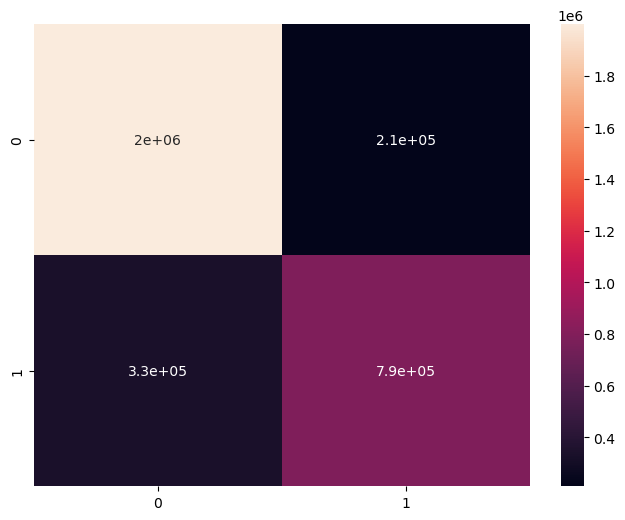

In [70]:
metrics(test.target, test.PCA)

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88   5156118
           1       0.79      0.70      0.74   2620165

    accuracy                           0.84   7776283
   macro avg       0.82      0.80      0.81   7776283
weighted avg       0.83      0.84      0.83   7776283

Specificity: 0.9046185521743296
Gini:  0.6072792624731083
ROC AUC::  0.8036396312365541


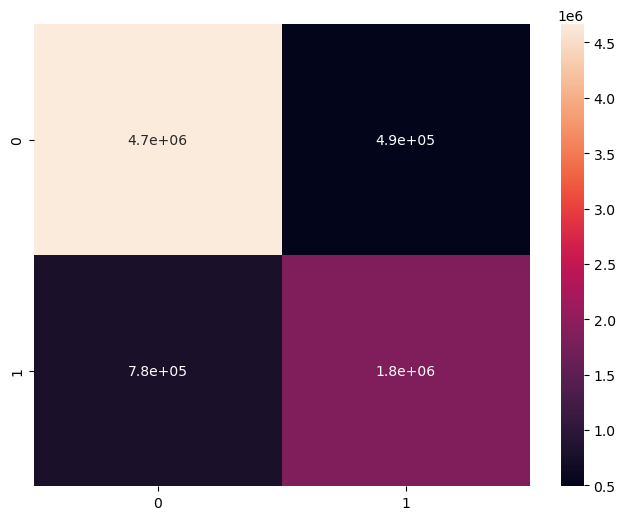

In [71]:
metrics(train.target, train.PCA)

#### LODA

In [2]:
with open('./models/LODA.pkl', 'rb') as f:
    clf_LODA = pickle.load(f) 

In [42]:
# y_train_scores_loda = clf_LODA.decision_scores_  # Outlier scores for training data
# test['score_LODA']= clf_LODA.decision_function(test[VARS])  # Outlier scores for test data

In [14]:
test['LODA']=clf_LODA.predict(test[VARS])

In [15]:
test['LODA'].value_counts()

LODA
0    2333930
1     998764
Name: count, dtype: int64

In [16]:
train['LODA']=clf_LODA.predict(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.82   2209766
           1       0.64      0.57      0.60   1122928

    accuracy                           0.75   3332694
   macro avg       0.72      0.70      0.71   3332694
weighted avg       0.74      0.75      0.74   3332694

Specificity: 0.8382086610075455
Gini:  0.4092541777281189
ROC AUC::  0.7046270888640594


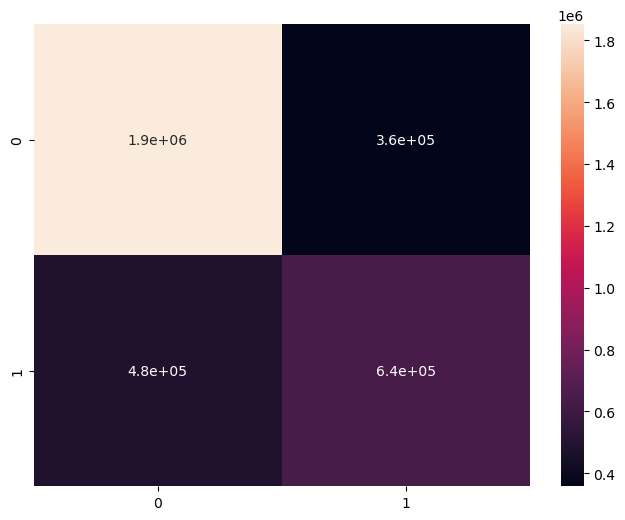

In [18]:
metrics(test.target, test.LODA)

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.82   5156118
           1       0.64      0.57      0.60   2620165

    accuracy                           0.75   7776283
   macro avg       0.72      0.70      0.71   7776283
weighted avg       0.74      0.75      0.74   7776283

Specificity: 0.8378710494988671
Gini:  0.4091820165562854
ROC AUC::  0.7045910082781427


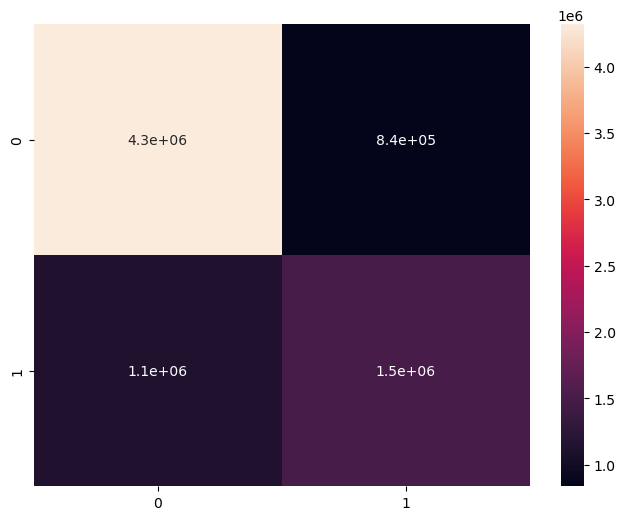

In [19]:
metrics(train.target, train.LODA)

### Local Outlier Factor

In [74]:
with open('./models/LOF.pkl', 'rb') as f:
    clf_LOF = pickle.load(f) 

In [75]:
test['LOF']=clf_LOF.predict(test[VARS])
# test['score_LOF']=clf_LOF.decision_function(test[VARS])
test['LOF'] = test['LOF'].apply(lambda x: 1 if x<0 else 0)

In [76]:
train['LOF']=clf_LOF.predict(train[VARS])
# train['score_LOF']=clf_LOF.decision_function(train[VARS])
train['LOF'] = train['LOF'].apply(lambda x: 1 if x<0 else 0)

Classification Report: 
               precision    recall  f1-score   support

           0       0.68      0.62      0.65   2209766
           1       0.37      0.43      0.40   1122928

    accuracy                           0.56   3332694
   macro avg       0.52      0.53      0.52   3332694
weighted avg       0.58      0.56      0.56   3332694

Specificity: 0.6207539621842313
Gini:  0.05099436940535318
ROC AUC::  0.5254971847026766


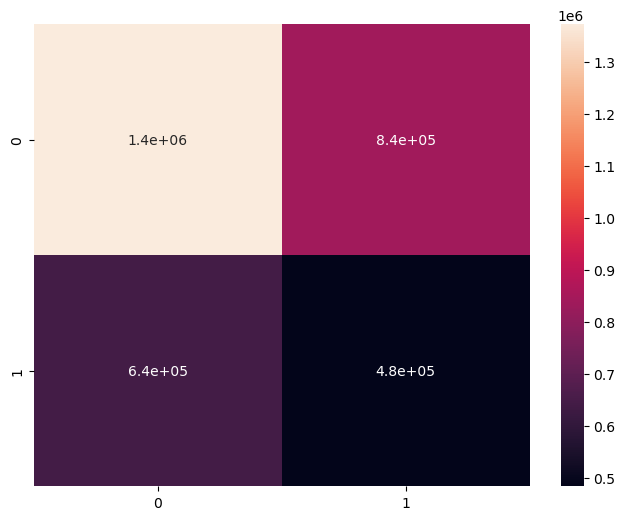

In [77]:
metrics(test.target, test.LOF)

Classification Report: 
               precision    recall  f1-score   support

           0       0.68      0.79      0.73   5156118
           1       0.39      0.26      0.31   2620165

    accuracy                           0.61   7776283
   macro avg       0.53      0.52      0.52   7776283
weighted avg       0.58      0.61      0.59   7776283

Specificity: 0.7941181718494418
Gini:  0.04930591765934311
ROC AUC::  0.5246529588296716


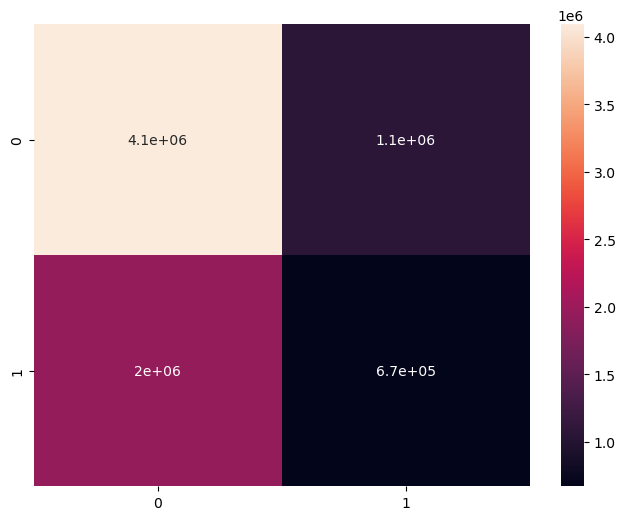

In [78]:
metrics(train.target, train.LOF)